# Gestion de portefeuille - Part 1
François Goujon

Content : Stocks statistical analysis and portfolio optimization with Mean Variance Model.

### Table of Contents
* [Stat analysis](#stat)
    * [1 - Stock analysis](#stock)
        * [Functions](#stock_func)
        * [Plots](#stock_plots)
            
    * [2 - Market correlation](#stocks)
        * [Functions](#stocks_func)
        * [Plots](#stocks_plots)
            * [CAC40 top 10](#stocks_cac40_10)
            * [CAC40](#stocks_cac40)
    
* [Portfolio optimization](#pf)
    * [Functions](#pf_func)
    * [Results](#pf_res)
        * [Min variance model](#pf_minvar)
        * [Markovitz model](#pf_mark)
        * [Efficient Frontier](#pf_front)
        * [Portfolio Allocation](#pf_alloc)
        * [Add of risk free asset - Tangency Portfolio](#pf_tgt)
        * [Factor model](#factor_model)
        * [Factor model estimation using PCA](#factor_model_pca)
        
* [Annex: Factor model](#factor_model_annex)

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cvxopt.solvers import qp
from cvxopt import matrix

## Stat analysis <a class="anchor" id="stat"></a>
### 1 - Stock analysis : returns, volatility, autocorrelation <a class="anchor" id="stock"></a>
#### Functions <a class="anchor" id="stock_func"></a>

In [2]:
def get_data(ticker, start = None, end = None, days = 365, log = True, plot = False):
    """
    Retrieve data from yfinance
    Input: ticker (String)
    start : "2020-01-01", end: "2022-01-01"
    Output: price dataframe (pd.DataFrame)
    """
    if end is None:
        end = datetime.datetime.now()
    if start is None:
        start = end - datetime.timedelta(days=days+1)
    df = yf.Ticker(ticker).history(start=start, end=end, period="1d")
    df.index = df.index.to_series().dt.date # Remove hours, minutes and secondes
    df = df[["Close"]]
    if log:
        df["Returns"] = np.log(df["Close"].pct_change(1) + 1)
    else:
        df["Returns"] = df["Close"].pct_change(1)
    df["SquaredReturns"] = df["Returns"]**2
    df.dropna(inplace=True)
    if plot:
        plot_returns(df)
    return df

def plot_price(data):
    data[["Close"]].plot(figsize=(12,6))
    plt.show()

def plot_returns(df):
    fig, axs = plt.subplots(3, 1, figsize=(15, 7))
    df[["Close"]].plot(ax = axs[0])
    axs[0].set_ylabel("Price")
    df[["Returns"]].plot(ax = axs[1])
    axs[1].set_ylabel("1Day Return")
    df[["SquaredReturns"]].plot(ax = axs[2])
    axs[2].set_ylabel("1Day Squared Return")
    plt.show()

def hist_returns(df):
    n = len(df)
    fig, axs = plt.subplots(2, 1, figsize=(10, 7))
    weights = np.ones(n)/float(n)
    df[["Returns"]].hist(bins=30, ax = axs[0], weights=weights)
    axs[0].set_xlabel("Return")
    axs[0].set_ylabel("Density")
    df[["SquaredReturns"]].hist(bins=30, ax = axs[1], weights=weights)
    axs[1].set_xlabel("Squared Return")
    axs[1].set_ylabel("Density")
    plt.show()

def autocorr(x, method="pd"):
    def autocorr_np(x):
        result = np.correlate(x, x, mode='full')
        return result[result.size//2:][1:41]

    def autocorr_pd(x):
        ac = np.zeros(40)
        for lag in range(1, 41):
            ac[lag-1] = x.autocorr(lag)
        return ac
    ac = autocorr_np(x) if method=="np" else autocorr_pd(x)
    return ac

def autocorr_returns(df, method="pd", plot=True):
    ret = df["Returns"]
    ret2 = df["SquaredReturns"]
    absret = np.abs(ret)
    ac = autocorr(ret, method=method)
    ac2 = autocorr(ret2, method=method)
    absac = autocorr(absret, method=method)
    if plot:
        fig, axs = plt.subplots(1, 3, figsize=(20, 4))
        for ax, ac_ in zip(axs, [ac, ac2, absac]):
            ax.grid()
            ax.scatter(list(range(1,41)), ac_)
            ax.bar(list(range(1,41)), ac_, width=0.1)
            ax.set_xlabel("Lag")
            ax.set_ylabel("Autocorr")
        axs[0].set_ylim([-0.2, 0.2])
        axs[1].set_ylim([-0.05, 0.3])
        axs[2].set_ylim([-0.05, 0.3])
        axs[0].set_title("Autocorr Returns")
        axs[1].set_title("Autocorr Squared Returns")
        axs[2].set_title("Autocorr Abs Returns")
        plt.plot()
    return ac, ac2, absac

def plot_volatility_window(df, window_days=40):
    """Plot volatility overtime by calculating it over a window_days window"""
    vol = df["Returns"].rolling(window=window_days).std()*np.sqrt(252)
    vol = vol.dropna()
    vol.plot(figsize=(10,3))
    plt.title("Volatility")
    plt.ylabel("Vol")
    plt.show()
    return vol

### Plots <a class="anchor" id="stock_plots"></a>

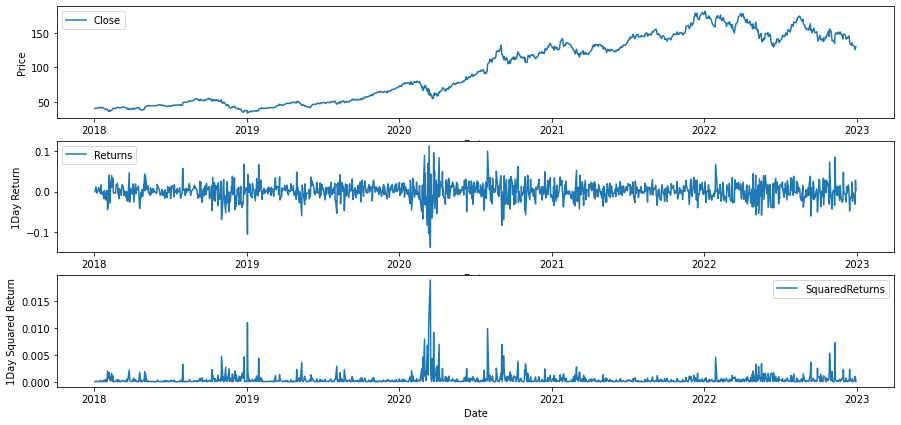

In [3]:
da = get_data("AAPL", start="2018-01-01", end="2023-01-01", plot=True)

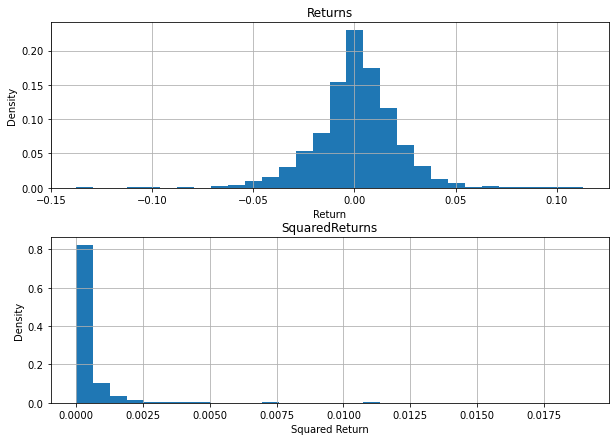

In [4]:
hist_returns(da) #Histogram

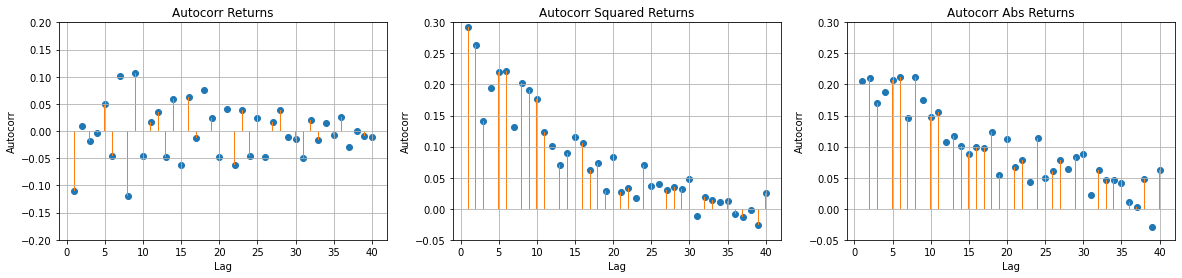

In [5]:
ac, ac2, absac = autocorr_returns(da) # Autocorrelation

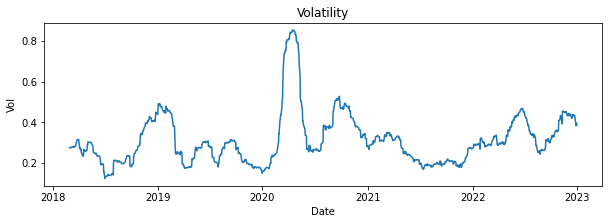

In [6]:
_ = plot_volatility_window(da)

## 2 - Market correlation <a class="anchor" id="stocks"></a>
#### Functions <a class="anchor" id="stocks_func"></a>

In [7]:
CAC_40 = {'MC.PA': 'LVMH', 'OR.PA': "L'Oréal", 'RMS.PA': 'Hermès', 'TTE': 'TotalEnergies', 'SNY': 'Sanofi',
            'AIR.PA': 'Airbus', 'SU.PA': 'Schneider Electric', 'BNP.PA': 'BNP', 'EL.PA': 'EssilorLuxottica',
            'AI.PA': 'Air Liquide', 'KER.PA': 'Kering', 'CS.PA': 'AXA', 'DG.PA': 'Vinci', 'SAF.PA': 'Safran',
            'DSY.PA': 'Dassault Systèmes', 'RI.PA': 'Ricard', 'STLA': 'Stellantis', 'STM': 'STMicroelectronics',
            'ACA.PA': 'Crédit Agricole', 'BN.PA': 'Danone', 'ENGI.PA': 'ENGIE', 'CAP.PA': 'Capgemini', 'SGO.PA': 'Saint-Gobain',
            'ORAN': 'Orange', 'HO.PA': 'Thales', 'MT': 'ArcelorMittal', 'LR.PA': 'Legrand', 'ML.PA': 'Michelin',
            'GLE.PA': 'Société Générale', 'VIE.PA': 'Veolia', 'PUB.PA': 'Publicis', 'TEP.PA': 'Teleperformance',
            'ERF.PA': 'Eurofins Scientific', 'WLN.PA': 'Worldline', 'CA.PA': 'Carrefour', 'RNO.PA': 'Renault',
            'EN.PA': 'Bouygues', 'ALO.PA': 'Alstom', 'VIV.PA': 'Vivendi', 'URW.AS': 'Unibail Rodamco Westfield'}

CAC_40_SHORT = {'MC.PA': 'LVMH', 'OR.PA': "L'Oréal", 'RMS.PA': 'Hermès', 'TTE': 'TotalEnergies', 'SNY': 'Sanofi',
            'AIR.PA': 'Airbus', 'SU.PA': 'Schneider Electric', 'BNP.PA': 'BNP', 'EL.PA': 'EssilorLuxottica',
            'AI.PA': 'Air Liquide'}

def get_index_data(index, start = None, end = None, days = 365, log=True):
    """
    Retrieve data from yfinance
    Input: indice (String)
    Output: price dataframe (pd.DataFrame)
    """
    compo_list = {"CAC40": CAC_40.keys(),
                 "CAC40_short": CAC_40_SHORT.keys()}

    tickers = " ".join(compo_list[index])
    if end is None:
        end = datetime.datetime.now()
    if start is None:
        start = end - datetime.timedelta(days=days+1)
    price_df = yf.Tickers(tickers).history(start=start, end=end, period="1d")
    price_df = price_df["Close"]
    if log:
        returns_df = np.log(price_df.pct_change(1) + 1)
    else:
        returns_df = price_df.pct_change(1)
    returns_df.dropna(inplace=True)
    squared_returns_df = returns_df**2
    dfs = {"price": price_df, "returns": returns_df, "squared_returns": squared_returns_df}
    return dfs

def get_names(returns):
    return returns.columns.to_list()  

def mean_yearly_return(returns):
    myr = returns.mean()*252*100
    mean_df = myr.reset_index().rename(columns={"index":"Ticker", 0: "MeanYearlyReturn(%)"})
    return mean_df

def get_correlation(returns):
    return returns.corr()

def plot_correlation(corr):
    if type(corr) == list:
        n = len(corr)
        row = int(np.ceil(n//2))
        col = 2
        fig, axs = plt.subplots(row, col, figsize=(20,8))
        for i, ax in enumerate(axs.flatten()[:n]):
            im = ax.matshow(corr[i])
            fig.colorbar(im, ax=ax)
    else:
        fig, ax = plt.subplots(figsize=(16,8))
        im = ax.matshow(corr)
        fig.colorbar(im, ax=ax)
    plt.show()

def get_maxmin_corr(corr):
    sorted_corr = corr.unstack().sort_values(ascending=False)
    scorr_df = sorted_corr.to_frame().reset_index().rename(columns={"level_0": "Ticker_1", "level_1":"Ticker_2", 0: "Correlation"})
    scorr_df = scorr_df[scorr_df["Correlation"] != 1]
    scorr_df = scorr_df.drop_duplicates(subset="Correlation")
    top = scorr_df.head(5)
    less = scorr_df.tail(5)
    res = pd.concat([top, less])
    return res

def plot_pca(corr):
    n = corr.shape[1] if corr.shape[1] < 10 else 10
    pca = PCA(n_components=n)
    pca.fit(corr)
    plt.figure(figsize=(15, 4))
    plt.bar(list(range(1,n+1)), pca.explained_variance_ratio_, label="Explained variance ratio")
    plt.plot(list(range(1,n+1)), pca.explained_variance_ratio_.cumsum(), "--", c="r", label="Cumulative explained variance ratio")
    plt.xlabel("Components")
    plt.ylabel("% Contribution")
    plt.title("PCA on correlation")
    plt.legend()
    plt.show()

def get_mean_cov(returns):
    m = np.array(returns.mean())
    c = returns.cov().values
    return m, c

### Plots <a class="anchor" id="stocks_plots"></a>

In [8]:
cac = get_index_data("CAC40_short", start="2018-01-01", end="2023-01-01")
cacr = cac["returns"]
cac_22 = get_index_data("CAC40_short", start="2022-01-01", end="2023-01-01")
cacr_22 = cac_22["returns"]

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


#### Top 10 CAC40 <a class="anchor" id="stocks_cac40_10"></a>

In [9]:
mean_yearly_return(cacr)

,Ticker,MeanYearlyReturn(%)
0,AI.PA,10.422651
1,AIR.PA,7.233582
2,BNP.PA,4.007951
3,EL.PA,9.216837
4,MC.PA,21.943305
5,OR.PA,13.578591
6,RMS.PA,23.879103
7,SNY,6.120772
8,SU.PA,14.816545
9,TTE,8.322403


In [10]:
mean_yearly_return(cacr).sort_values("MeanYearlyReturn(%)", ascending=False).head(3) # TOP 3

,Ticker,MeanYearlyReturn(%)
6,RMS.PA,23.879103
4,MC.PA,21.943305
8,SU.PA,14.816545


In [11]:
corr = get_correlation(cacr)
corr_22 = get_correlation(cacr_22)
corr

,AI.PA,AIR.PA,BNP.PA,EL.PA,MC.PA,OR.PA,RMS.PA,SNY,SU.PA,TTE
AI.PA,1.000000,0.473894,0.479489,0.519286,0.614407,0.595824,0.548995,0.382333,0.679198,0.387860
AIR.PA,0.473894,1.000000,0.638311,0.481315,0.556279,0.384200,0.456531,0.198542,0.558191,0.429404
BNP.PA,0.479489,0.638311,1.000000,0.490612,0.541354,0.390111,0.379183,0.256123,0.591696,0.579318
EL.PA,0.519286,0.481315,0.490612,1.000000,0.604745,0.570174,0.576623,0.222280,0.585629,0.272264
MC.PA,0.614407,0.556279,0.541354,0.604745,1.000000,0.665572,0.776090,0.286161,0.668246,0.430566
OR.PA,0.595824,0.384200,0.390111,0.570174,0.665572,1.000000,0.635634,0.318515,0.585209,0.286081
RMS.PA,0.548995,0.456531,0.379183,0.576623,0.776090,0.635634,1.000000,0.194735,0.601447,0.264854
SNY,0.382333,0.198542,0.256123,0.222280,0.286161,0.318515,0.194735,1.000000,0.324798,0.379230
SU.PA,0.679198,0.558191,0.591696,0.585629,0.668246,0.585209,0.601447,0.324798,1.000000,0.421730
TTE,0.387860,0.429404,0.579318,0.272264,0.430566,0.286081,0.264854,0.379230,0.421730,1.000000


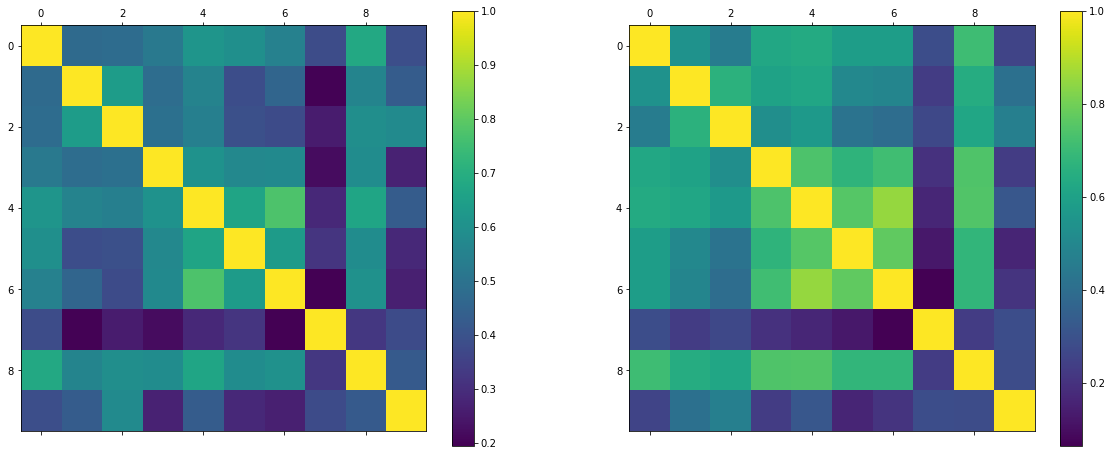

In [12]:
plot_correlation([corr, corr_22])

#### CAC 40 <a class="anchor" id="stocks_cac40"></a>

[*********************100%***********************]  40 of 40 completed


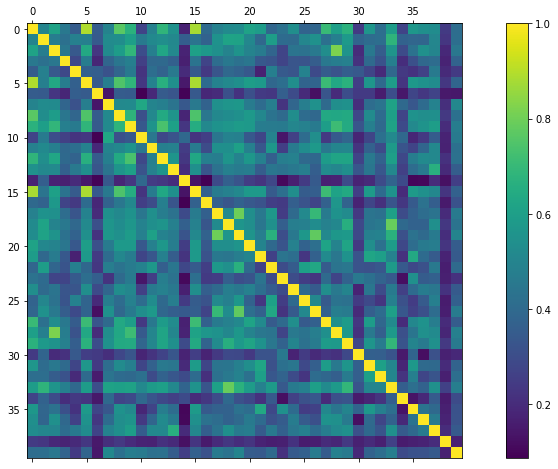

,Ticker_1,Ticker_2,Correlation
40,ACA.PA,BNP.PA,0.892083
42,GLE.PA,BNP.PA,0.884239
44,GLE.PA,ACA.PA,0.878810
46,AIR.PA,SAF.PA,0.818890
48,KER.PA,MC.PA,0.798848
1590,ERF.PA,URW.AS,0.105262
1592,ERF.PA,TTE,0.103036
1594,ERF.PA,CA.PA,0.096260
1596,HO.PA,ERF.PA,0.088880
1598,DSY.PA,CA.PA,0.086484


In [13]:
cac_all = get_index_data("CAC40", start="2018-01-01", end="2023-01-01")["returns"]
names_all = get_names(cac_all)
corr_all = get_correlation(cac_all)
plot_correlation(corr_all)
get_maxmin_corr(corr_all)

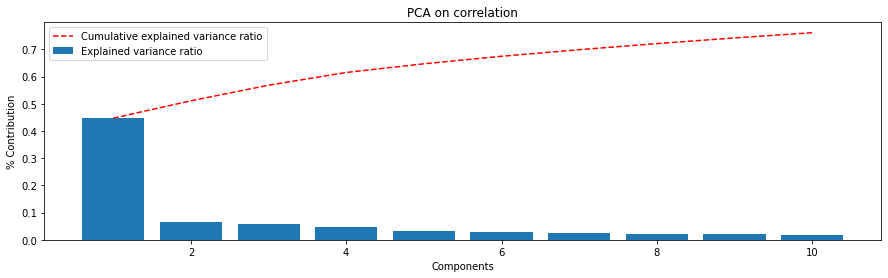

In [14]:
plot_pca(cac_all)

## Portfolio optimization <a class="anchor" id="pf"></a>

#### Mean-Variance Model
Returns : $R_{i,t} \sim N(\mu_i, \sigma_i^2)$ asset $i$ at time $t$ <br>
$R_t = [R_{1,t}, R_{2,t}, ..., R_{n,t}]^T \in \mathcal{R}^n$ ($R = [R_{t_1}, R_{t_2}, ..., R_{t_T}] \in \mathcal{R}^{n\times T}$) <br>
$cov(R_i, R_j) = \sigma_{i,j} \ ; \ \Sigma = (\sigma_{i,j})$ <br>
Weights : $\sum w_i = 1$ <br>
Expected return : $w^T\mu = \mu_w$ and Variance : $w^T\Sigma w = \sigma_w^2$ <br>
Portfolio return : $R_{p,w} \sim N(\mu_w, \sigma_w^2)$ and $cov(R_{p,w_1}, R_{p,w_2}) = w_1^T\Sigma w_2$

#### Function qp from cvxopt : 
$$
\text{qp(P, q, G, h, A, b) resolves}:  \quad \quad \quad \quad \quad
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{min}}
& \frac{1}{2}x^T P x + q^T x \\
& \text{subject to}
\\
& & G x \leq h \\
& & A x = b
\end{aligned}
\end{equation*}

#### Functions <a class="anchor" id="pf_func"></a>

In [82]:
def get_sum_const(nb_asset):
    a = np.ones((1,nb_asset), dtype=float)
    b = np.array([1.0]) 
    return a, b

def get_return_const(true_ret, exp_ret):
    d_er = exp_ret/252
    a = true_ret
    b = np.array([d_er])
    return a, b

def get_sector_const(sector_load, exp_load):
    a = sector_load
    b = np.array(exp_load)
    return a, b

def pf_opti(cov_ret, mean_ret, func = "min_var", exp_ret=None, rfr=0.0, short=False, f_load=None, exp_f=None, verbose=False):
    nb_asset = cov_ret.shape[0]
    d_rfr = rfr/252
    true_ret = mean_ret - d_rfr
    p = cov_ret
    # PF optimization type
    if func == "min_var":
        q = np.zeros(nb_asset)
        eq_cond = True
    elif func == "max_sharpe":
        q = - true_ret
        eq_cond = False
    else:
        raise("Wrong func")
    # Weight positivity : If short allowed -> no condition 
    if short:
        g = np.zeros((nb_asset, nb_asset))
    else:
        g = -np.eye(nb_asset)
    h = np.zeros(nb_asset)
    # Markovitz model : Expected return
    a_consts = []
    b_consts = []
    if exp_ret is not None:
        a_ret, b_ret = get_return_const(true_ret, exp_ret)
        a_consts.append(a_ret)
        b_consts.append(b_ret)
    if eq_cond:
        a_eq, b_eq = get_sum_const(nb_asset)
        a_consts.append(a_eq)
        b_consts.append(b_eq)
    if f_load is not None and exp_f is not None:
        a_load, b_load = get_sector_const(f_load, exp_f)
        a_consts.append(a_load)
        b_consts.append(b_load)
    # QP solving
    if eq_cond: 
        a = np.vstack(a_consts)
        b = np.hstack(b_consts)
        params = [p, q, g, h, a, b]
    else:
        params = [p, q, g, h]
    params = list(map(matrix, params))
    sol = qp(*params, options={"show_progress":verbose})
    w = np.array(sol["x"]).ravel()
    if not eq_cond:
        w /= np.sum(w)
    if short:
        w[np.abs(w) < 0.005] = 0 # Cleaning small weights
    else:
        w[w < 0.005] = 0
        if np.abs(np.sum(w) - 1) > 0.05:
            w = np.zeros(nb_asset)
    return w


def get_pf_info(cov, mean, weights, verbose=True):
    mu_daily = weights@mean
    var_daily = (weights@cov)@weights
    mu = 252*mu_daily
    var = 252*var_daily
    std = np.sqrt(var)
    leverage = np.sum(np.abs(weights))
    if verbose:
        print(f"Expected yearly return = {round(mu, 3)} ; Expected var = {round(var, 3)} (std = {round(std,3)}) ; Leverage = {round(leverage,3)}")
    return mu, std

def frontier_compute(cov, mean, rfr = 0.0, f_load = None, exp_f = None):
    arrs = {}
    arrs["mus"] = np.arange(0.0, 0.4, 0.005)
    arrs["weights_l"] = np.array([pf_opti(cov, mean, exp_ret=mu, rfr=rfr) for mu in arrs["mus"]])
    arrs["weights_ls"] = np.array([pf_opti(cov, mean, exp_ret=mu, rfr=rfr, short = True) for mu in arrs["mus"]])
    arrs["stds_l"] = np.array([get_pf_info(cov, mean, w, False)[1] for w in arrs["weights_l"]])
    arrs["stds_ls"] = np.array([get_pf_info(cov, mean, w, False)[1] for w in arrs["weights_ls"]])
    arrs["sharp_ratio_l"] = np.divide(arrs["mus"], arrs["stds_l"], where = arrs["stds_l"]!=0, out=np.zeros_like(arrs["mus"]))
    arrs["sharp_ratio_ls"] = np.divide(arrs["mus"], arrs["stds_ls"], where = arrs["stds_ls"]!=0, out=np.zeros_like(arrs["mus"]))
    return arrs

def plot_frontier(data):
    mus_l, mus_ls = data['mus'], data['mus']
    stds_l, stds_ls = data["stds_l"], data["stds_ls"]
    best_sharp_l = np.argmax(data["sharp_ratio_l"])
    best_sharp_ls = np.argmax(data["sharp_ratio_ls"])
    sharpe_mu_l, sharpe_std_l =  mus_l[best_sharp_l], stds_l[best_sharp_l]
    sharpe_mu_ls, sharpe_std_ls =  mus_ls[best_sharp_ls], stds_ls[best_sharp_ls]
    good_idx = stds_l>0
    stds_l, mus_l = stds_l[good_idx], mus_l[good_idx]
    if len(stds_l) > 0:
        best_idx_l = np.argmin(stds_l)
        print(f"Min Var Long only : mu = {mus_l[best_idx_l]} ; sigma = {round(stds_l[best_idx_l],3)}")
    best_idx_ls = np.argmin(stds_ls)
    print(f"Min Var Long Short : mu = {mus_ls[best_idx_ls]} ; sigma = {round(stds_ls[best_idx_ls],3)}")
    print(f"Max Sharpe Long only : mu = {sharpe_mu_l} ; sigma = {round(sharpe_std_l,3)}")
    print(f"Max Sharpe Long Short : mu = {sharpe_mu_ls} ; sigma = {round(sharpe_std_ls,3)}")
    plt.figure(figsize=(7, 5))
    plt.plot(stds_l, mus_l, ".", label="Long only", c="b")
    plt.plot(stds_ls, mus_ls, ".", label="Long Short", c="r")
    plt.xlabel(r"$\sigma$")
    plt.ylabel("Expected return")
    plt.xlim([0, 0.4])
    plt.show()

def plot_efficient_allocation(data, names):
    alloc_l = pd.DataFrame(data["weights_l"], index=data["stds_l"].round(2), columns=names)
    alloc_ls = pd.DataFrame(data["weights_ls"], index=data["stds_ls"].round(2), columns=names)
    fig, axs = plt.subplots(2, 1, figsize=(16, 8))
    alloc_l.plot(kind='bar', stacked=True, ax=axs[0])
    alloc_ls.plot(kind='bar', stacked=True, ax=axs[1])
    for ax in axs:
        ax2 = ax.twiny()
        ax2.set_xticks(ticks=ax.get_xticks(), labels=data["mus"].round(2), rotation=45)
        ax2.set_xlabel(r"$\mu$")
        ax.set_ylabel('Allocation')
        ax.set_xlabel(r"$\sigma$")
        ax.legend(title='Tickers', bbox_to_anchor=(1.0, 1), loc='upper left')
    axs[0].set_ylim([0, 1])
    axs[1].set_ylim([-1, 2])
    plt.tight_layout()
    plt.show()

def plot_tangent_allocation(weights_t, cov, mean, rfr, names):
    mu, std = get_pf_info(cov, mean, weights_t, False)
    alphas = np.arange(0, 1.4, 0.05)
    allocs = [weights_t*alpha for alpha in alphas]
    cash = 1 - alphas
    stds = std*alphas
    mus = (1-alphas)*rfr + alphas*mu
    # Create df
    alloc_df = pd.DataFrame(allocs, index=stds.round(2), columns=names)
    # Add cash 
    alloc_df["Cash"] = cash
    # Fig
    fig, ax = plt.subplots(figsize=(10, 5))
    alloc_df.plot(kind='bar', stacked=True, ax=ax)
    ax2 = ax.twiny()
    ax2.set_xticks(ticks=ax.get_xticks(), labels=mus.round(2), rotation=45)
    ax2.set_xlabel(r"$\mu$")
    ax.set_ylabel('Allocation')
    ax.set_xlabel(r"$\sigma$")
    ax.legend(title='Tickers', bbox_to_anchor=(1.0, 1), loc='upper left')
    #ax.set_ylim([-4, 4])
    plt.tight_layout()
    plt.show()


### Results <a class="anchor" id="pf_res"></a>

In [16]:
mean_r, cov_r = get_mean_cov(cacr)
names = get_names(cacr)
mean_r_22, cov_r_22 = get_mean_cov(cacr_22)

#### Min Variance Portfolio <a class="anchor" id="pf_minvar"></a>

$$
\begin{equation*}
\begin{aligned}
& \underset{w}{\text{min}}
& w^T\Sigma w \\
& \text{subject to}
\\
& &  1^T w = 1 \\
& & \text{if long only : } \forall i,\ w_i \geq 0 
\end{aligned}
\end{equation*}
$$
This is "min_var" option of pf_opti with exp_ret = None

In [17]:
w = pf_opti(cov_r, mean_r, func="min_var")
print(w.round(3))
_= get_pf_info(cov_r, mean_r, w)
print(round(sum(w), 3))

[0.28  0.    0.    0.116 0.    0.104 0.12  0.347 0.    0.03 ]
Expected yearly return = 0.106 ; Expected var = 0.03 (std = 0.173) ; Leverage = 0.997
0.997


In [18]:
w = pf_opti(cov_r, mean_r, func="min_var", short=True)
print(w.round(3))
_= get_pf_info(cov_r, mean_r, w)
print(round(sum(w), 3))

[ 0.348 -0.04   0.034  0.16  -0.196  0.145  0.253  0.328 -0.101  0.068]
Expected yearly return = 0.098 ; Expected var = 0.028 (std = 0.168) ; Leverage = 1.673
1.0


#### Markovitz Model <a class="anchor" id="pf_mark"></a>
$$
\begin{equation*}
\begin{aligned}
& \underset{w}{\text{min}}
& w^T\Sigma w \\
& \text{subject to}
\\
& & \mu^T w = \mu^* \\
& & 1^T w = 1 \\
& & \text{if long only : } \forall i,\ w_i \geq 0
\end{aligned}
\end{equation*}
$$
This is "min_var" option of pf_opti with exp_ret = $\mu^*$

In [19]:
w = pf_opti(cov_r, mean_r, exp_ret=0.2)
print(w.round(3))
_= get_pf_info(cov_r, mean_r, w)
print(round(sum(w), 3))

[0.032 0.    0.    0.    0.047 0.006 0.73  0.185 0.    0.   ]
Expected yearly return = 0.2 ; Expected var = 0.048 (std = 0.218) ; Leverage = 0.999
0.999


In [20]:
w = pf_opti(cov_r, mean_r, exp_ret=0.2, short=True)
print(w.round(3))
_= get_pf_info(cov_r, mean_r, w)
print(round(sum(w), 3))

[ 0.193 -0.116 -0.108 -0.041  0.087  0.046  0.618  0.213  0.023  0.084]
Expected yearly return = 0.2 ; Expected var = 0.043 (std = 0.208) ; Leverage = 1.529
1.0


#### Efficient frontier <a class="anchor" id="pf_front"></a>

Min Var Long only : mu = 0.1 ; sigma = 0.173
Min Var Long Short : mu = 0.1 ; sigma = 0.168
Max Sharpe Long only : mu = 0.34500000000000003 ; sigma = 0.248
Max Sharpe Long Short : mu = 0.325 ; sigma = 0.318


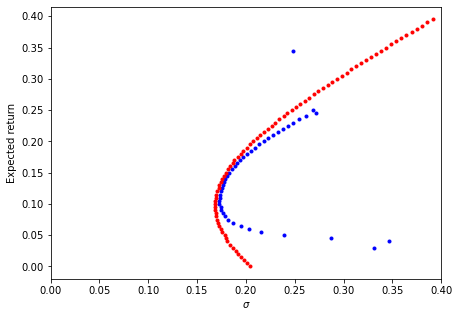

In [68]:
frontier_data = frontier_compute(cov_r, mean_r)
plot_frontier(frontier_data)

Min Var Long only : mu = 0.08 ; sigma = 0.173
Min Var Long Short : mu = 0.08 ; sigma = 0.168
Max Sharpe Long only : mu = 0.27 ; sigma = 0.256
Max Sharpe Long Short : mu = 0.335 ; sigma = 0.349


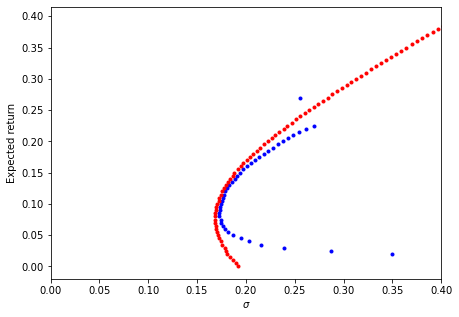

In [32]:
frontier_data_rfr = frontier_compute(cov_r, mean_r, rfr=0.02) # Shift figure down
plot_frontier(frontier_data_rfr)

Min Var Long only : mu = 0.0 ; sigma = 0.191
Min Var Long Short : mu = 0.01 ; sigma = 0.186
Max Sharpe Long only : mu = 0.395 ; sigma = 0.346
Max Sharpe Long Short : mu = 0.395 ; sigma = 0.299


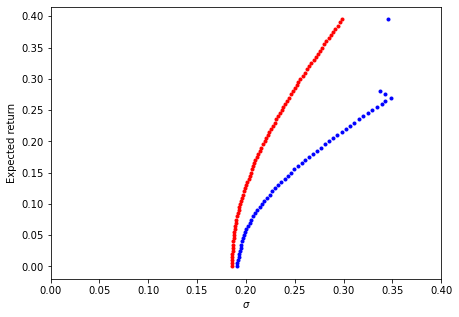

In [33]:
frontier_data_22 = frontier_compute(cov_r_22, mean_r_22)
plot_frontier(frontier_data_22)

#### Portfolio Allocation <a class="anchor" id="pf_alloc"></a>

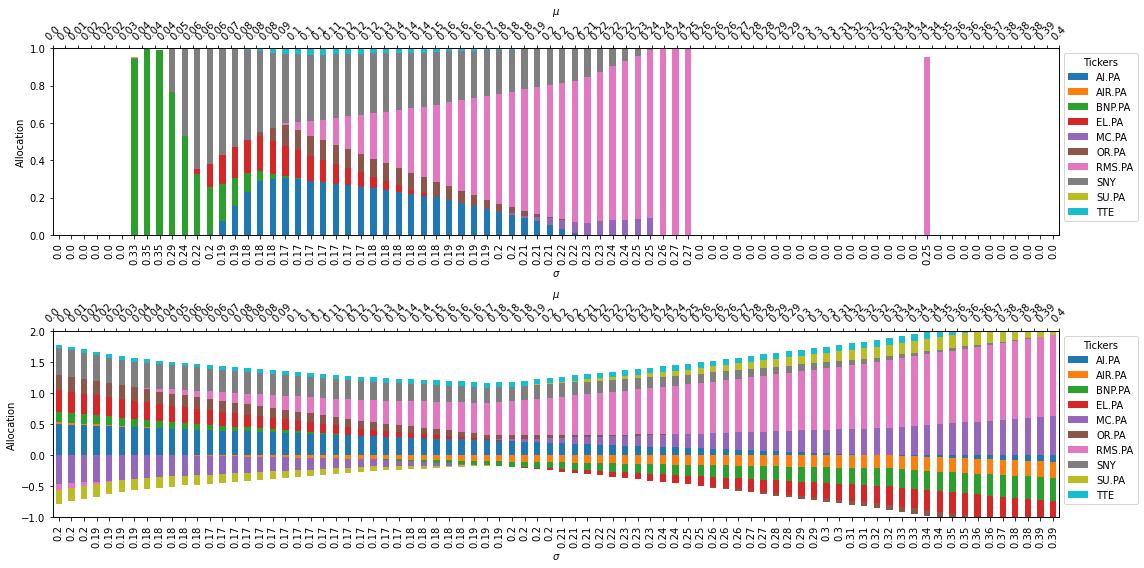

In [34]:
plot_efficient_allocation(frontier_data, names)

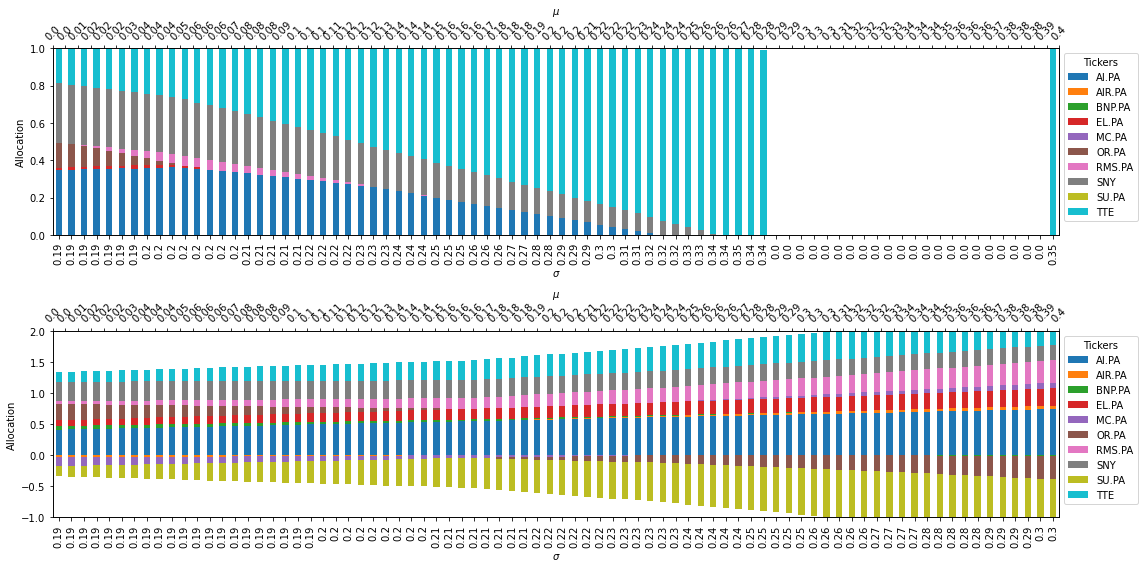

In [35]:
plot_efficient_allocation(frontier_data_22, names)

#### Addition of a risk free asset - Tangency Portfolio <a class="anchor" id="pf_tgt"></a>
Risk free asset : $\mu = r_f$ and $\sigma = 0$ <br>
The tangency portfolio corresponds to the point on the efficient frontier where the slope of the tangent passing throught $r_f$ is maximized. Slope : $\frac{\mu_p - r_f}{\sigma_p}$. Indeed, we will build a pf composed of : <br>
$$
(1-\alpha) * RiskFreeAsset \ + \alpha *TangencyPF
$$ <br>
so that : <br>
$$
\text{Expected return} = (1-\alpha) r_f + \alpha \mu_p \\
\text{std} = \alpha \sigma_p \\
$$
The optimization problem is :
$$
\begin{equation*}
\begin{aligned}
& \underset{w}{\text{max}}
& \frac{\mu_p - r_f}{\sigma_p}\\
& \text{subject to}
& 1^T w = 1 \\
\end{aligned}
\end{equation*}
$$
Finding an equivalent problem : <br>
$$\frac{\mu_p - r_f}{\sigma_p} = \frac{w^T \mu - r_f}{\sqrt{w^T \Sigma w}} = \frac{w^T (\mu - R_f)}{\sqrt{w^T \Sigma w}} = \frac{w^T \tilde{\mu}}{\sqrt{w^T \Sigma w}} \text{  with } R_f = [r_f \ r_f \ ... \ r_f]^T \text{ and  } \tilde{\mu} = \mu - R_f \quad (w^T R_f = r_f \ as \sum w_i = 1)
\\ 
\Rightarrow
\begin{equation*}
\begin{aligned}
& \underset{w}{\text{max}}
& \frac{w^T \tilde{\mu}}{\sqrt{w^T \Sigma w}}\\
& \text{subject to}
& 1^T w = 1 \\
\end{aligned}
\end{equation*}
$$
We can see in this expression that the value is unchanged when $w$ is multiplied by a constant, we can maximize to find $w$ and then normalize to 1. This becomes : 
$$
\underset{w}{\text{max}} \frac{w^T \tilde{\mu}}{\sqrt{w^T \Sigma w}} \text{, and then } w = \frac{w}{sum(w)}
$$
To find max value we fix $w^T \tilde{\mu} = \mu^*$ and minimize variance :
$$
\begin{equation*}
\begin{aligned}
& \underset{w}{\text{max}}
& \frac{w^T \tilde{\mu}}{\sqrt{w^T \Sigma w}} = \frac{\mu^*}{\sqrt{w^T \Sigma w}}\\
& \text{subject to}
& \tilde{\mu}^T w = \mu^* \\
\end{aligned}
\end{equation*}
\quad \quad \quad \quad \Rightarrow \quad \quad \quad \quad
\begin{equation*}
\begin{aligned}
& \underset{w}{\text{min}}
& w^T \Sigma w \\
& \text{subject to}
& \tilde{\mu}^T w = \mu^* \\
\end{aligned}
\end{equation*}
\quad \quad \text{ for any } \mu^* > 0 \text{ and then } w = \frac{w}{sum(w)}
$$ 
Which is equivalent to : 
$$
\underset{w}{\text{min}} \ w^T \Sigma w - \tilde{\mu}^T w \quad \text{ and then } w = \frac{w}{sum(w)}
$$
This is "max_sharpe" func option of pf_opti.

In [60]:
w_tpf = pf_opti(cov_r, mean_r, func="max_sharpe", rfr = 0.02)
print(w_tpf.round(3))
_= get_pf_info(cov_r, mean_r, w_tpf)
print(round(sum(w_tpf), 3))

[0.    0.    0.    0.    0.092 0.    0.902 0.005 0.    0.   ]
Expected yearly return = 0.236 ; Expected var = 0.065 (std = 0.256) ; Leverage = 1.0
1.0


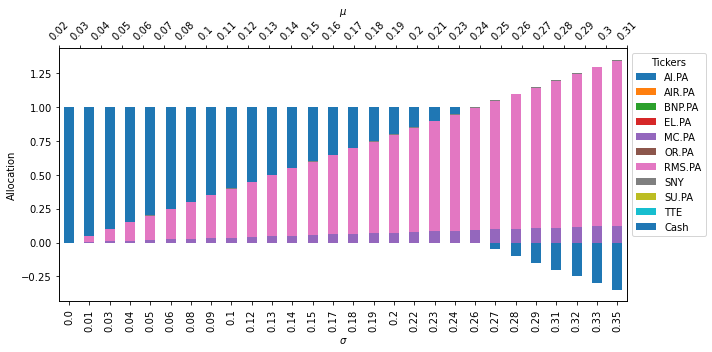

In [61]:
plot_tangent_allocation(w_tpf, cov_r, mean_r, 0.02, names)

In [62]:
w_tpf = pf_opti(cov_r, mean_r, func="max_sharpe", rfr = 0.02, short=True)
print(w_tpf.round(3))
_= get_pf_info(cov_r, mean_r, w_tpf)
print(round(sum(w_tpf), 3))

[-0.045 -0.233 -0.324 -0.349  0.521 -0.106  1.178  0.038  0.213  0.108]
Expected yearly return = 0.357 ; Expected var = 0.123 (std = 0.351) ; Leverage = 3.116
1.0


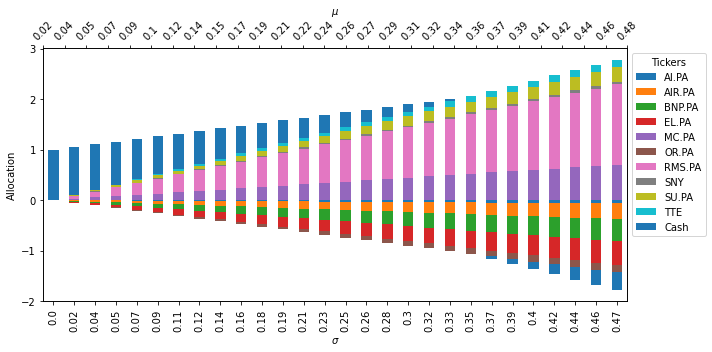

In [63]:
plot_tangent_allocation(w_tpf, cov_r, mean_r, 0.02, names)

#### Factor covariance model <a class="anchor" id="factor_model"></a>

Modeling the covariance matrix $\Sigma$ as a factor model (see annex for more details) : 
$$
\Sigma = F \Sigma_S F^T + \Sigma_{\epsilon}
$$
where $F \in \mathcal{R}^{n\times k}, \ k << n$ is the factor loading matrix. $k$ is the number of factors (or sectors). $F_{ij}$ is the loading of asset $i$ to factor $j$. <br>
$\Sigma_S > 0, \in \mathcal{R}^{k\times k}$ is the factor covariance matrix. <br>
$\Sigma_{\epsilon}$ is white noise covariance <br>
$F^T w \in \mathcal{R}^k$ gives the portfolio factor exposures. A portfolio is factor $j$ neutral if $(F^T w)_j = 0$. <br>
<br>
Portfolio optimization with factor covariance model : 
$$
\begin{equation*}
\begin{aligned}
& \underset{w}{\text{min}}
& w^T (F \Sigma_S F^T + \Sigma_{\epsilon}) w \\
& \text{subject to}
\\
& & \mu^T w = \mu^* \\
& & 1^T w = 1 \\
& & \text{if long only : } \forall i,\ w_i \geq 0
\end{aligned}
\end{equation*}
$$
But we can see that : <br>
$$ 
w^T (F \Sigma_S F^T + \Sigma_{\epsilon}) w = w^T F \Sigma_S F^T w + w^T \Sigma_{\epsilon} w = {f^*}^T \Sigma_S f^* + w^T \Sigma_{\epsilon} w
$$
If we constrain $F^T w = f^*$, the problem becomes : 
$$
\begin{equation*}
\begin{aligned}
& \underset{w}{\text{min}}
& w^T \Sigma_{\epsilon} w \\
& \text{subject to}
\\
& & \mu^T w = \mu^* \\
& & F^T w = f^* \\
& & 1^T w = 1 \\
& & \text{if long only : } \forall i,\ w_i \geq 0
\end{aligned}
\end{equation*}
$$

Using the factor covariance model in the optimization problem has a computational advantage. The solve time is 𝑂(𝑛𝑘2) versus 𝑂(𝑛3) for the standard problem.

### Estimating factors with PCA <a class="anchor" id="factor_model_pca"></a>

In [106]:
def get_factor_model(returns, k_components=5):
    pca = PCA(n_components=k_components).fit(returns)
    f = -pca.components_ # f = + ou - vec, - so that every asset correlated to first component which is the market.
    d = np.diag(pca.explained_variance_)
    approx = f.T@d@f
    sigma_noise = returns.cov().values - approx
    return f, sigma_noise

def frontier_compute_factor(cov, mean, noise_cov, f_load, exp_f):
    arrs = {}
    arrs["mus"] = np.arange(0.0, 0.4, 0.005)
    arrs["weights_l"] = np.array([pf_opti(noise_cov, mean, exp_ret=mu, f_load=f_load, exp_f=exp_f) for mu in arrs["mus"]])
    arrs["weights_ls"] = np.array([pf_opti(noise_cov, mean, exp_ret=mu, short = True, f_load=f_load, exp_f=exp_f) for mu in arrs["mus"]])
    arrs["stds_l"] = np.array([get_pf_info(cov, mean, w, False)[1] for w in arrs["weights_l"]])
    arrs["stds_ls"] = np.array([get_pf_info(cov, mean, w, False)[1] for w in arrs["weights_ls"]])
    arrs["sharp_ratio_l"] = np.divide(arrs["mus"], arrs["stds_l"], where = arrs["stds_l"]!=0, out=np.zeros_like(arrs["mus"]))
    arrs["sharp_ratio_ls"] = np.divide(arrs["mus"], arrs["stds_ls"], where = arrs["stds_ls"]!=0, out=np.zeros_like(arrs["mus"]))
    return arrs

In [109]:
f3, s_noise3 = get_factor_model(cacr, k_components=3)

In [135]:
w3 = pf_opti(s_noise3, mean_r, func = "min_var", exp_ret=None, rfr=0.0, short=True, f_load=f3, exp_f=[0.3, 0.3, -0.3], verbose=False)
print(w3.round(3))
_= get_pf_info(cov_r, mean_r, w3)
print(round(sum(w3), 3))

[-0.115 -0.21   0.008  0.072  0.541  0.188  0.062 -0.078  0.382  0.149]
Expected yearly return = 0.203 ; Expected var = 0.068 (std = 0.26) ; Leverage = 1.805
1.0


Min Var Long Short : mu = 0.20500000000000002 ; sigma = 0.26
Max Sharpe Long only : mu = 0.0 ; sigma = 0.0
Max Sharpe Long Short : mu = 0.31 ; sigma = 0.324


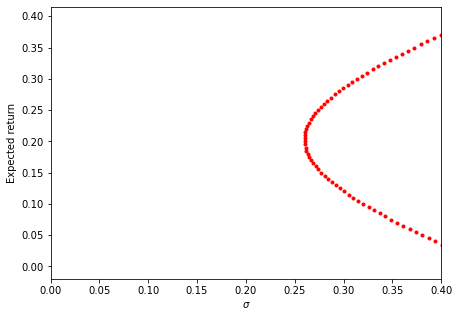

In [136]:
frontier_data = frontier_compute_factor(cov_r, mean_r, s_noise3, f_load=f3, exp_f=[0.3, 0.3, -0.3])
plot_frontier(frontier_data)

## Black-Litterman <a class="anchor" id="black-litterman"></a>

$$
R \sim N(\mu, \Sigma) \\
\mu \sim N(\Pi, \tau \Sigma) \\
\text{ i.e } \mu = \Pi + \epsilon^{(e)} \text{ with } \epsilon^{(e)} \sim N(0, \tau \Sigma)
$$
$\tau \in \mathcal{R^+}$ indicates the uncertainty of the prior <br>
Views are expressed as portfolios whose returns are independent random normal variables : 
$$
P \mu = Q + \epsilon^{(v)} \text{ with } \epsilon^{(v)} \sim N(0, \Omega)
$$
where rows of $P = {w_{P,i}}^T$ indicates the weights of a portfolio which return will be $Q_i$ with a confidence level of $\frac{1}{\theta_{ii}}$. $\Omega$ is a diagonal matrix with $\theta_{ii}$ on its diagonal.

Lemma : GLS Linear Model
$$
Y = X\Beta + E
$$
with $Cov(E|X) = \Omega = \sigma^2 V$, then :
$$
\hat{\Beta} = (X^T \Omega^{-1} X)^{—1} X^T \Omega^{-1} Y \\
(\ \hat{\Beta} \sim N( \ (X^T \Omega^{-1} X)^{—1} X^T \Omega^{-1} Y, \ (X^T \Omega^{-1} X)^{—1} \ ) \ )
$$

We want to resolve  : 


$$
\begin{bmatrix}
\Pi \\
Q
\end{bmatrix}
=
\begin{bmatrix}
I \\
P
\end{bmatrix}
\mu
+
\begin{bmatrix}
\epsilon^{(e)} \\
\epsilon^{(v)}
\end{bmatrix}
$$
GLS resolves to : 
$$
\mu |(\Pi, P, Q)\sim N(\mu^*, M^{-1}) \\
\mu^* = [(\tau \Sigma)^{-1} + P^T \Omega^{-1} P]^{-1}[(\tau \Sigma)^{-1} \Pi + P^T \Omega^{-1} Q] \\
M^{-1} = [(\tau \Sigma)^{-1} + P^T \Omega^{-1} P]^{-1}
$$
then :
$$
R \sim N(\mu^*, \Sigma^*) \\
\text{with } \Sigma^* = \Sigma + M^{-1} \\
$$

In [ ]:
# TODO

### Annex : Factor model <a class="anchor" id="factor_model_annex"></a>

We model : <br>
$$
R_t = FS_t + \alpha + \epsilon \in \mathcal{R}^{n} \\
F \in \mathcal{R}^{n \times k} \text{ : Factor loading matrix}\\
S_t \in \mathcal{R}^{k} \text{ : Factor/Sector returns at time t, }\\
cov(S) = \Sigma_S \text{ and } E(S) = \mu_S \\ 
\alpha \in \mathcal{R^n} \text{ : Specific component}\\
\epsilon \in \mathcal{R}^{n} \text{ : White noise}
$$
Then : <br>
$$
\mu = \alpha + F\mu_S \\
\Sigma = F\Sigma_S F^T + \Sigma_{\epsilon}
$$
$\Sigma_{\epsilon, ii}$ is the idiosyncratic risk of asset $i$. <br>
#### PCA Method
To find F we start by diagonalizing $\Sigma$ (Meaning a PCA on the returns)
$$
\Sigma = V\Lambda V^T \text{ with : } \Lambda = diag(\lambda_1, \lambda_2, ..., \lambda_n) \text{ , } \lambda_1, \lambda_2, ..., \lambda_n > 0 \\
V \text{ is orthogonal}
$$
Let $V = [V_k, V_{n-k}]$, $V_k$ are the $k$ first eigenvectors <br>
We take $F = V_k$, $\alpha = \mu$ and $S_t = V_k^T(R_t - \mu) = F^T(R_t - \mu)$ <br>
Then : <br>
$$
\mu_S = F^T(\mu - \mu) = 0 \\
\Sigma_S = F^T(R_t - \mu)(R_t - \mu)^T F = F^T \Sigma F = \Lambda_k \\
\quad \\
\epsilon = R_t - FS_t - \alpha = R_t - FF^T(R_t - \mu) - \mu 
= V_{n-k}V_{n-k}^T(R_t - \mu) \quad \text{ as } V_kV_k^T + V_{n-k}V_{n-k}^T = VV^T = I \\
E(\epsilon) = 0 \\
cov(\epsilon) = V_{n-k}V_{n-k}^T(R_t - \mu)(R_t - \mu)^TV_{n-k}V_{n-k}^T = V_{n-k}V_{n-k}^T \Sigma V_{n-k}V_{n-k}^T = V_{n-k}\Lambda_{n-k}V_{n-k}^T
$$
We verify that $\Sigma = F\Sigma_S F^T + \Sigma_{\epsilon}$ : 
$$
F\Sigma_S F^T + \Sigma_{\epsilon} = V_k \Lambda_k V_k^T + V_{n-k}\Lambda_{n-k}V_{n-k}^T = V \Lambda V^T = \Sigma
$$

#### Sector loadings

In [156]:
CAC_40_10_SECTOR = {"LVMH": "Consommation", "L'Oréal": "Consommation", "Hermès": "Consommation", "TotalEnergies": "Energie", "Sanofi": "Santé",
                "Airbus": "Industrie", "Schneider Electric": "Equipement", "BNP": "Finance", "EssilorLuxottica": "Santé",
                "Air Liquide": "Industrie", "Kering": "Consommation", "AXA": "Finance", "Vinci": "Construction", "Safran": "Industrie",
                "Dassault Systèmes": "Equipement", "Ricard": "Food", "Stellantis": "Automobile", "STMicroelectronics": "Equipement",
                "Crédit Agricole": "Finance", "Danone": "Food", "ENGIE": "Energie", "Capgemini": "Info", "Saint-Gobain": "Construction",
                "Orange": "Info", "Thales": "Industrie", "ArcelorMittal": "Industrie", "Legrand": "Equipement", 
                "Michelin": "Automobile", "Société Générale": "Finance", "Veolia": "Energie", "Publicis": "Info", "Teleperformance": "Info",
                "Eurofins Scientific": "Santé", "Worldline": "Finance", "Carrefour": "Food", "Renault": "Automobile",
                "Bouygues": "Construction", "Alstom": "Industrie", "Vivendi": "Info", "Unibail Rodamco Westfield": "Consommation"}

In [175]:
f10, s_noise10 = get_factor_model(cac_all, k_components=10)
df = pd.DataFrame.from_dict({"Sector":CAC_40_10_SECTOR}).reset_index()
df = pd.concat([df, pd.DataFrame(f10.T)], axis=1)

In [178]:
df

,index,Sector,0,1,2,3,4,5,6,7,8,9
0,AXA,Finance,0.196561,-0.164399,0.017591,0.031499,-0.162673,-0.112048,0.039898,0.161492,0.081624,-0.068735
1,Air Liquide,Industrie,0.101022,0.116891,0.023502,0.001547,-0.083943,0.049547,0.032929,-0.130521,-0.054492,0.014368
2,Airbus,Industrie,0.227575,-0.028412,0.232373,-0.100628,0.284874,-0.357007,0.119423,-0.050607,-0.100771,0.241787
3,Alstom,Industrie,0.134746,0.024177,0.058051,-0.010835,-0.008787,-0.013407,-0.239987,-0.007294,0.098808,0.229411
4,ArcelorMittal,Industrie,0.070281,0.051750,0.075724,0.040715,-0.170392,0.054009,0.008805,-0.223133,-0.002305,0.026374
5,BNP,Finance,0.204151,-0.192924,0.037666,0.027772,-0.156552,-0.141992,0.007272,0.130906,0.035882,-0.034367
6,Bouygues,Construction,0.072206,-0.061034,0.013625,0.076093,-0.228609,0.079246,0.142364,-0.249005,0.032209,-0.039221
7,Capgemini,Info,0.148464,0.207129,0.042262,-0.050773,0.063810,0.008753,0.013496,0.107072,0.073037,-0.065463
8,Carrefour,Food,0.154959,-0.072497,0.049957,0.015492,-0.086128,-0.052335,0.015271,-0.001644,0.051026,-0.041632
9,Crédit Agricole,Finance,0.174351,-0.016340,0.120498,-0.038259,-0.024726,-0.070410,0.044299,-0.174359,0.018552,0.087647


In [180]:
df.groupby("Sector").mean()

,0,1,2,3,4,5,6,7,8,9
Sector,,,,,,,,,,
Automobile,0.146017,-0.054215,-0.139962,0.018657,-0.063313,0.067433,-0.065555,-0.088519,0.022232,0.058946
Consommation,0.159852,-0.030148,-0.000138,-0.013660,-0.001192,-0.055077,0.022448,-0.035546,-0.073066,-0.062745
Construction,0.152887,-0.089035,0.045756,0.034985,-0.196947,0.099471,0.000322,-0.070527,0.048168,0.030603
Energie,0.165309,-0.011180,0.151232,-0.008325,0.118974,0.242539,0.226574,0.038483,0.112400,-0.047237
Equipement,0.133689,0.108715,0.047815,-0.029800,-0.086528,0.005867,-0.069026,-0.015818,-0.114171,-0.074095
Finance,0.159853,-0.017425,0.015660,-0.005918,-0.045604,-0.090861,-0.029423,-0.030374,0.144110,-0.048445
Food,0.135551,0.063548,0.033431,0.007993,-0.049793,0.068401,0.007976,0.053771,0.052560,-0.126961
Industrie,0.133006,0.089604,0.067118,-0.023958,-0.018663,-0.049901,-0.040041,-0.061335,-0.063644,0.073549
Info,0.159269,0.108475,-0.179220,0.149705,0.110740,0.001731,0.019142,-0.001550,-0.047517,-0.045182


PCA sectors obviously have no economic interpretation except first component which can be referred to as the market.